# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Откройте файл с данными и изучите общую информацию. 

Импортируем данные в датасет:

In [67]:
import pandas as pd
import numpy as np
data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')

Изучаем общую информацию о полученных данных:

In [68]:
pd.set_option('display.max_columns', None)
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,False,False,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [69]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

Построение гистограмм:

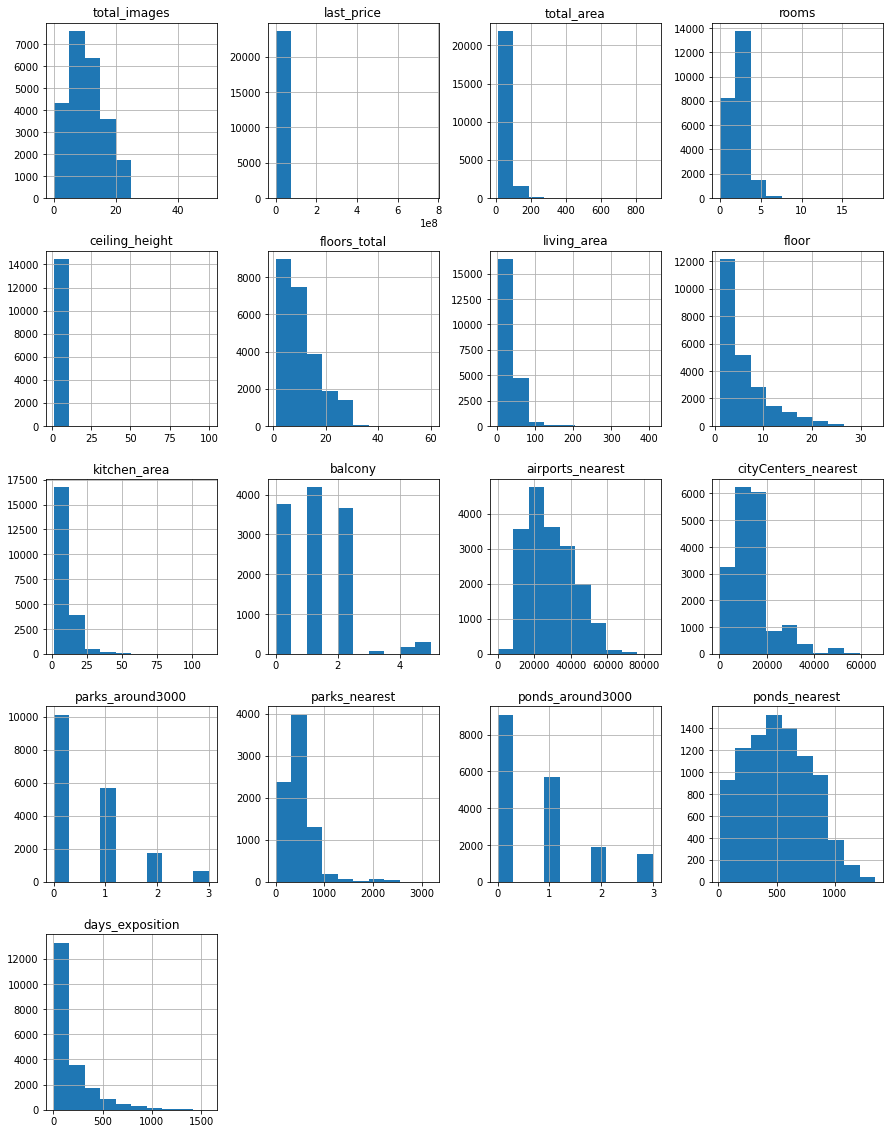

In [70]:
data.hist(figsize=(15, 20));

### Предобработка данных

Переименуем столбцы:

In [71]:
data.rename(columns={'cityCenters_nearest' : 'city_centers_nearest'}, inplace=True)

 Пропущенные значения:

In [72]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
city_centers_nearest     5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

Описание пропущеных значений

Количество обнаруженных `Null` из `23699`:

`9195 ceiling_height` - практически в трети объявлений пропущена высота потолков, оставим `Null`

`86 floors_total` - данные просто не заполнили, из выборки, оставим `Null`

`1903 living_area` - оставим `Null`

`2775 is_apartment` - значений, можем предположить что это не апартаменты и присвоить `False`

`2278 kitchen_area` - проверить не студия ли это? Если нет, то оставим `Null`

`11519 balcony` - скорее всего там нет балконов, заполняем `0`

`49 locality_name` - данные просто не заполнили, оставим `Null`

`5542 airports_nearest` - аэропортов рядом нет, оставляем `Null`

`5519 city_centers_nearest` - центр города не близко, оставляем `Null`

`5518 parks_around3000` - значит парков нет в радиусе 3км, оставляем `Null`

`15620 parks_nearest` - значит парков нет, оставляем `Null`

`5518 ponds_around3000` - значит прудов нет в радиусе 3км, оставляем `Null`

`14589 ponds_nearest` - оставляем `Null`

`3181 days_exposition` - объявление не было опубликовано, оставляем `Null`

In [73]:
def pass_value_barh(df):
    (
        (df.isna().mean()*100)
        .to_frame()
        .rename(columns = {0:'space'})
        .query('space > 0')
        .sort_values(by = 'space', ascending = True)
        .plot(kind= 'barh', figsize=(19,6), rot = -5, legend = False, fontsize = 16)
        .set_title('Пример' + "\n", fontsize = 22)    
    );    

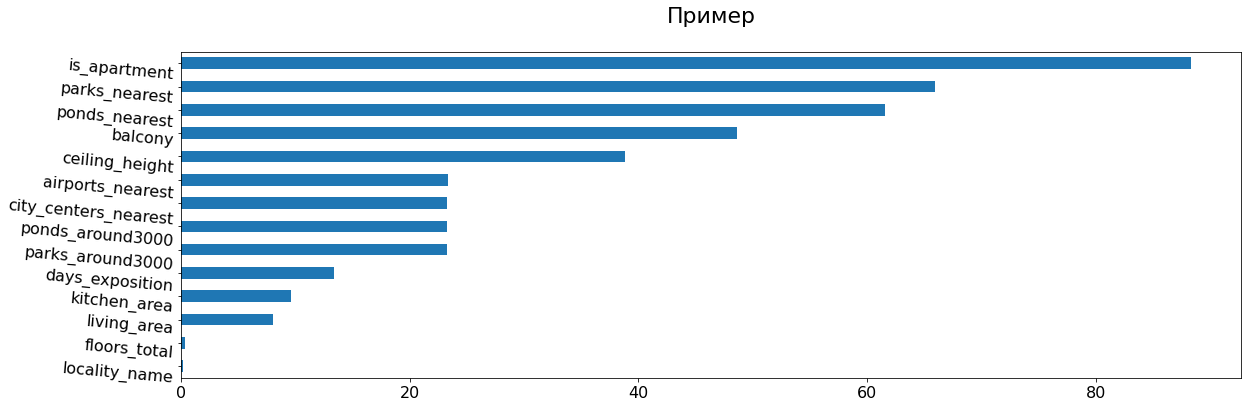

In [74]:
pass_value_barh(data)

Заполнем Null апартаменты как 'False'

In [75]:
data['is_apartment'] = data['is_apartment'].fillna('False')

Заполнем Null балконы как '0':

In [76]:
data['balcony'] = data['balcony'].fillna(0)

Удалем строки с Null locality_name:

In [77]:
data['locality_name'].dropna(inplace=True)

Удалем строки с Null floors_total:

In [78]:
data['floors_total'].dropna(inplace=True)

Обрабатываем пропуски в ceiling_height

In [79]:
# функция, получающая на вход название признака, и возвращающая число пропущенных значений
def print_nan_ratio(column):
    return print('Пропущено {:.1%}'. format(data[column].isna().value_counts()[1] / len(data), 2) + ' значений')

In [80]:
print_nan_ratio('ceiling_height')
ceiling_medians = data.pivot_table(index='floors_total', values='ceiling_height', aggfunc=['median', 'count'])
ceiling_medians.columns = ['median', 'count']
ceiling_medians.head()

Пропущено 38.8% значений


,median,count
floors_total,,
1.0,2.80,10
2.0,2.70,215
3.0,2.80,399
4.0,3.00,789
5.0,2.55,3666


In [81]:
# заменяем значения высоты потолков на общую медиану для отсутствующих значений этажности дома
for floor in ceiling_medians.index:
    data.loc[(data['floors_total'].isna()) | 
             ((data['floors_total'] == floor) & (ceiling_medians.loc[floor, 'count'] == 0)), 
             'ceiling_height'] = data['ceiling_height'].describe()[5]

# медианы из сгруппированной таблицы вставляем на места пропущенных значений высоты потолков для дома соответствующей этажности
for floor in ceiling_medians.index:
    data.loc[(data['ceiling_height'].isna()) & 
             (data['floors_total'] == floor), 
             'ceiling_height'] = ceiling_medians.loc[floor, 'median']

# посчитаем количество пропущенных значений после проделанной замены
data['ceiling_height'].isna().value_counts()

False    23699
Name: ceiling_height, dtype: int64

**Типы данных**

In [82]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        23699 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          23699 non-null  object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               23699 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

Сменить тип данных для:

- last_price - int64
- first_day_exposition - date
- floors_total - Int8 nullable-integer extension dtype
- is_apartment - bool
- balcony - int8
- days_exposition - int64

Изменение типа `first_day_exposition` необходимо, чтобы работать с датой в дальнейшем было удобно.

Изменение типа `is_apartment` необходимо, чтобы работать с булевым значением и сэкономить память.
Изменение типов во всех остальных случаях необзодимо, чтобы сэкономить память.

Использование `try` чтобы выявить ошибки при преобразовании типов.

In [83]:
try:
    data['last_price'] = data['last_price'].astype('int64')
    print('1ok')
except:
    print('last_price int type conversion fail')
    
try:    
    data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'],format='%Y-%m-%dT%H:%M:%S')
    print('2ok')
except:
    print('first_day_exposition to_datetime type conversion fail')
    
try:
    data['floors_total'] =  data['floors_total'].astype('Int8')
    print('3ok')
except:
    print('floors_total int8 type conversion fail')
      
try:
    data['is_apartment'] = data['is_apartment'].map({'False':False, 'True':True})
    print('4ok')
except:
    print('is_apartment bool type conversion fail')
        
try:
    data['balcony'] = data['balcony'].astype('int8')
    print('5ok')
except:
    print('balcony int8 type conversion fail')
    
try:
    data['days_exposition'] = np.floor(pd.to_numeric(data['days_exposition'], errors='coerce')).astype('Int64')
    print('6ok')
except:
    print('days_exposition int64 type conversion fail')

1ok
2ok
3ok
4ok
5ok
6ok


In [84]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23699 non-null  int64         
 1   last_price            23699 non-null  int64         
 2   total_area            23699 non-null  float64       
 3   first_day_exposition  23699 non-null  datetime64[ns]
 4   rooms                 23699 non-null  int64         
 5   ceiling_height        23699 non-null  float64       
 6   floors_total          23613 non-null  Int8          
 7   living_area           21796 non-null  float64       
 8   floor                 23699 non-null  int64         
 9   is_apartment          20924 non-null  object        
 10  studio                23699 non-null  bool          
 11  open_plan             23699 non-null  bool          
 12  kitchen_area          21421 non-null  float64       
 13  balcony         

**Изучение уникальных значений**

In [85]:
def loc_length():
    return print('Количество уникальных значений locality_name:', data['locality_name'].unique().shape[0])
loc_length()

Количество уникальных значений locality_name: 365


Удаление дубликатов:

- приводим всё к нижнему регистру

- заменяем все "ё" на "е"

- заменяем "городской поселок" на "поселок городского типа"

- проверяем наличие явных дубликатов

Приводим всё к нижнему регистру:

In [86]:
data['locality_name'] = data['locality_name'].str.lower()

Заменяем все "ё" на "е":

In [87]:
data['locality_name'] = data['locality_name'].str.replace('ё', 'е')
print('Заменяем все "ё" на "е"')
loc_length()
print()

Заменяем все "ё" на "е"
Количество уникальных значений locality_name: 331



Заменяем "городской поселок" на "поселок городского типа":

In [88]:
data['locality_name'] = data['locality_name'].str.replace('городской поселок','поселок городского типа')
print('Заменяем "городской поселок" на "поселок городского типа"')
loc_length()
print()

Заменяем "городской поселок" на "поселок городского типа"
Количество уникальных значений locality_name: 324



Проверяем наличие явных дубликатов:

In [89]:
print('Количество явных дубликатов:', data.duplicated().sum())

Количество явных дубликатов: 0


**Устранение выбросов**

Распределение значений в данных:

In [90]:
data.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23699.000000,2.369900e+04,23699.000000,23699.000000,23699.000000,23613.000000,21796.000000,23699.000000,21421.000000,23699.000000,18157.000000,18180.000000,18181.000000,8079.000000,18181.000000,9110.000000,20518.000000
mean,9.858475,6.541549e+06,60.348651,2.070636,2.735602,10.673824,34.457852,5.892358,10.569807,0.591080,28793.672193,14191.277833,0.611408,490.804555,0.770255,517.980900,180.888634
std,5.682529,1.088701e+07,35.654083,1.078405,0.994274,6.597173,22.030445,4.885249,5.905438,0.959298,12630.880622,8608.386210,0.802074,342.317995,0.938346,277.720643,219.727988
min,0.000000,1.219000e+04,12.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.300000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.550000,5.000000,18.600000,2.000000,7.000000,0.000000,18585.000000,9238.000000,0.000000,288.000000,0.000000,294.000000,45.000000
50%,9.000000,4.650000e+06,52.000000,2.000000,2.650000,9.000000,30.000000,4.000000,9.100000,0.000000,26726.000000,13098.500000,0.000000,455.000000,1.000000,502.000000,95.000000
75%,14.000000,6.800000e+06,69.900000,3.000000,2.750000,16.000000,42.300000,8.000000,12.000000,1.000000,37273.000000,16293.000000,1.000000,612.000000,1.000000,729.000000,232.000000
max,50.000000,7.630000e+08,900.000000,19.000000,100.000000,60.000000,409.700000,33.000000,112.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000


`total_images` - выглядит хорошо, оставляем

`last_price` - взглянем на квартиры от 0 до 20 млн, нет квартир стоимостью 0.
Есть одна квартира стоимостью меньше 100 000, её мы учитывать не будем.
225 квартир стоимостью меньше 1млн - не похоже на выброс, оставляем.
Убираем слишком дорогие квартиры стоимостью больше 100.000.000.

In [91]:
print('Квартир стоимостью 0:', data.query('last_price == 0')['last_price'].count())
print('Квартир стоимостью меньше 100.000:', data.query('last_price < 1e+05')['last_price'].count())
print('Квартир стоимостью больше 100.000.000:', data.query('last_price > 1e+08')['last_price'].count())

print('Квартир стоимостью больше 100.000.000:', data.query('last_price > 1e+08')['last_price'].count())
data.drop(index=data.query('last_price > 1e+08').index,inplace=True)

Квартир стоимостью 0: 0
Квартир стоимостью меньше 100.000: 1
Квартир стоимостью больше 100.000.000: 37
Квартир стоимостью больше 100.000.000: 37


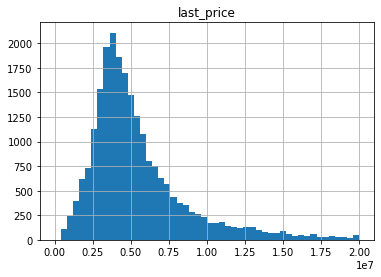

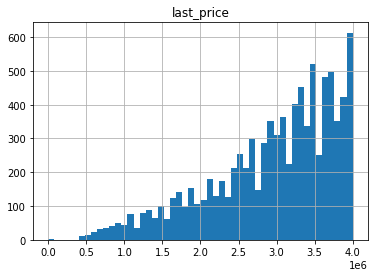

In [92]:
data.hist('last_price', bins=50, range=(0,2e+07));
data.hist('last_price', bins=50, range=(0,4e+06));

data.drop(index=data.query('last_price < 1e+05').index,inplace=True)

`total_area` - нет квартир площадью меньше 10 м2, но есть меньше 20 м2.
Это не похоже на аномалию.
Квартиры с площадью более 500 м2 похожи на элитную недвижимость, их немного и лучше удалить.

Квартир площадью менее 10 м2: 0
Квартир площадью более 500 м2: 3


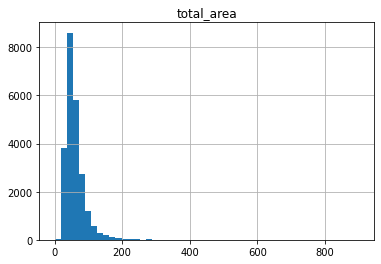

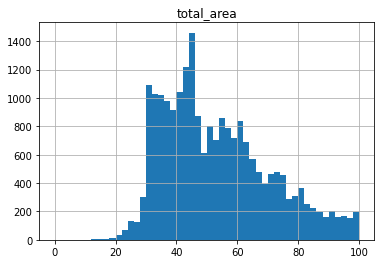

In [93]:
print('Квартир площадью менее 10 м2:',data.query('total_area < 10')['total_area'].count()) 
print('Квартир площадью более 500 м2:',data.query('total_area > 500')['total_area'].count())

data.drop(index=data.query('total_area > 500').index,inplace=True)

data.hist('total_area', bins=50, range=(0,900));
data.hist('total_area', bins=50, range=(0,100));

`rooms` - есть нулевые значения, 195.
Сделаем проверку - это студии, апартаменты или свободная планировка.
Квартиры без комнат не апартаменты и не свободная планировка - 0.
Максимальное значение комнат - 19.

In [94]:
print('Квартиры без комнат:',data.query('rooms == 0')['rooms'].count())

print('Квартиры без комнат и студии:',data.query('rooms == 0 and studio')['rooms'].count()) 

print('Квартиры без комнат и апартаменты:',data.query('rooms == 0 and is_apartment')['rooms'].count()) 

print('Квартиры без комнат и свободная планировка:',data.query('rooms == 0 and open_plan')['rooms'].count())

print('Квартиры без комнат не апартаменты и не свободная планировка:',data.query('rooms == 0 and ~open_plan and ~studio')['rooms'].count())

data.drop(index=data.query('rooms > 7').index,inplace=True)

Квартиры без комнат: 197
Квартиры без комнат и студии: 138
Квартиры без комнат и апартаменты: 0
Квартиры без комнат и свободная планировка: 59
Квартиры без комнат не апартаменты и не свободная планировка: 0


`ceiling_height` - высота потолков.
Этот параметр в жилых домах устанавливается с учетом требований, устанавливаемых строительными правилами (СП), санитарно-гигиеническими, архитектурными требованиями и т.д.
Независимо от года постройки и от типа здания, высота от пола до потолка должна быть в пределах 2,5-3,2 метров.
При изучении данных известно небольшое количество дорогих двухэтажнх пентхаусов с высотой потолков 4-5 м.
Можно предположить, что квартиры с высотой потолков 25-36 м на самом деле являются опечаткой и соотвествуют 2.5-3.6 м
Исходя их этого предполагаем, что все квартиры с высотой потолков от 36 м являются выбросами.
Более того, есть одно значение, которое показывает высоту потолков выше 50 метров.

In [95]:
print('Квартир с потолками от 4 до 5м: ' + str(data.query('ceiling_height > 4 and ceiling_height <= 5')['ceiling_height'].count()) + ' шт.')
print('Квартир с потолками от 5 до 25м: ' + str(data.query('ceiling_height > 5 and ceiling_height < 25')['ceiling_height'].count()) + ' шт.')
print('Квартир с потолками от 25м до 36м: ' + str(data.query('ceiling_height >= 25 and ceiling_height <= 36')['ceiling_height'].count()) + ' шт.')
print('Квартир с потолками от 25м до 36м: ' + str(data.query('ceiling_height > 36 and ceiling_height < 50')['ceiling_height'].count()) + ' шт.')
print('Квартир с потолками от 50м: ' + str(data.query('ceiling_height >= 50')['ceiling_height'].count()) + ' шт.')

Квартир с потолками от 4 до 5м: 36 шт.
Квартир с потолками от 5 до 25м: 15 шт.
Квартир с потолками от 25м до 36м: 19 шт.
Квартир с потолками от 25м до 36м: 0 шт.
Квартир с потолками от 50м: 1 шт.


Удаляем квартиры с высотой потолков от 4 до 25 метров.
Для квартир с высотой потолков до 25 до 36 метров предполагаем, что это опечатка и делим на 10, получая 2.5 и 3.6 метра.
Удаляем квартиры с высотой потолков от 36 метров:

In [96]:
data.drop(index=data.query('ceiling_height > 4 and ceiling_height < 25').index,inplace=True)

data.update(data[(data['ceiling_height'] >= 25) & (data['ceiling_height'] <= 36)]['ceiling_height']/10)

data.drop(index=data.query('ceiling_height > 36').index,inplace=True)

Изучим квартиры с высотой потолков более 2.5 метров:

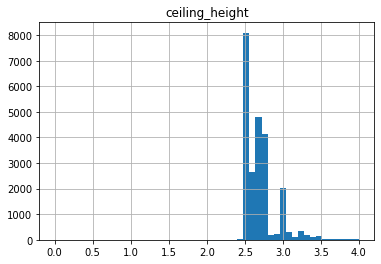

In [97]:
data.hist('ceiling_height',bins=50,range=(0,4));

Убираем из выборки квартиры с высотой потолков менее 2.5 м, так как это не соответствует строительным нормам:

In [98]:
print('Квартир с потолками меньше 2.5м : ' + str(data.query('ceiling_height < 2.5')['ceiling_height'].count()) + ' шт.')

data.drop(index=data.query('ceiling_height < 2.5').index,inplace=True)

Квартир с потолками меньше 2.5м : 73 шт.


`floors_total` - есть одноэтажные квартиры, но это не похоже на выброс. Также есть небольшое количество квартир в 30 и более этажных домах:

Квартир в одноэтажных домах :  23
Квартир в 30+ этажных домах :  30


array([[<AxesSubplot:title={'center':'floors_total'}>]], dtype=object)

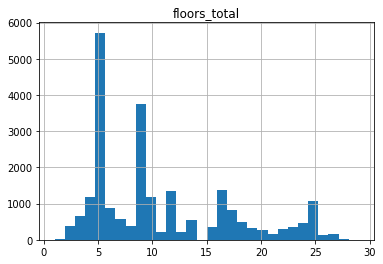

In [99]:
print('Квартир в одноэтажных домах : ',data.query('floors_total == 1')['floors_total'].count())
print('Квартир в 30+ этажных домах : ',data.query('floors_total > 30')['floors_total'].count())

data.drop(index=data.query('floors_total > 30').index,inplace=True)

data.hist('floors_total', bins=30)

`living_area` - имеем большое количество квартир с жилой площадью от 10 до 60 м2.
Здесь интересуют квартиры с жилой площадью меньше 10 м2 их 25 м2.
Судя по гистограмме есть квартиры с жилой площадью 2 м2.
Но это что-то странное, скорее всего опечатка в площади.
Отбросим значения с жилой площадью меньше 10 м2.
Отбросим квартиры с площадью более 200 м2.

Жилая площадь меньше 10 м2:  25
Жилая площадь больше общей:  0
Жилая площадь больше 200 м2:  12


array([[<AxesSubplot:title={'center':'living_area'}>]], dtype=object)

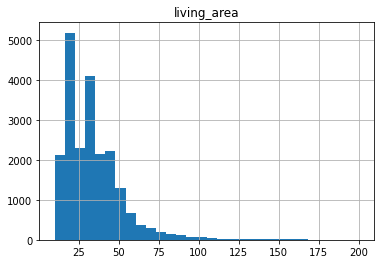

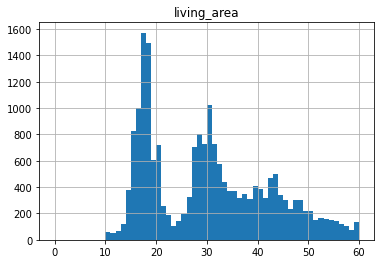

In [100]:
print('Жилая площадь меньше 10 м2: ',data.query('living_area < 10')['living_area'].count())
print('Жилая площадь больше общей: ',data.query('living_area > total_area')['living_area'].count())
print('Жилая площадь больше 200 м2: ',data.query('living_area > 200')['living_area'].count())

data.drop(index=data.query('living_area < 10').index,inplace=True)
data.drop(index=data.query('living_area > 200').index,inplace=True)

data.hist('living_area', bins=30);
data.hist('living_area', bins=60, range=(0,60))

`floor` - этаж. Здесь нет нулевых значений и слишком больших значений.
Проверим, есть ли значения этажа больше, чем этажность самого здания:

Этаж 0 0
Этаж 0 0
Этаж больше количества этажей здания:  0


array([[<AxesSubplot:title={'center':'floor'}>]], dtype=object)

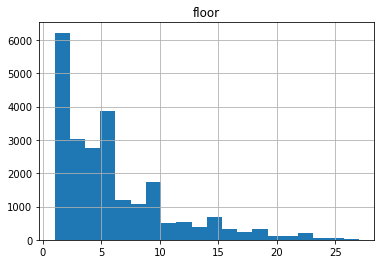

In [101]:
print('Этаж 0',data.query('floor == 0')['floor'].count())

print('Этаж 0',data.query('floor > 30')['floor'].count())

print('Этаж больше количества этажей здания: ',data.query('floor > floors_total')['floor'].count())

data.hist('floor',bins=20)

`kitchen_area` - площадь кухни. Здесь есть одна квартира с площадью кухни меньше 1 м2. Явная аномалия.
Много кухонь с площадью 5 м2. Кухонь с площадью более 30 м2 довольно мало.

Вывод - удалим строки с кухнями менее 2 м2 и больше 50 м2:

Площадь кухни меньше 2 м2:  1
Площадь кухни 5 м2:  351
Площадь кухни больше 50 м2:  33
Площадь кухни больше общей:  0


array([[<AxesSubplot:title={'center':'kitchen_area'}>]], dtype=object)

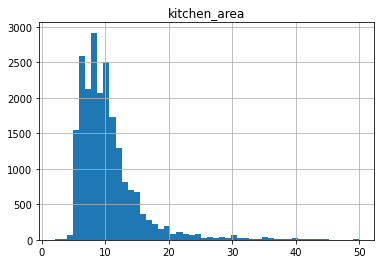

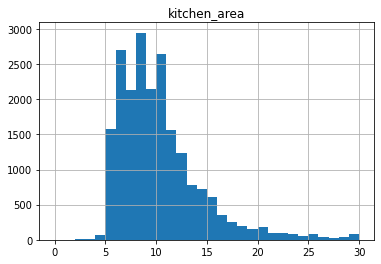

In [102]:
print('Площадь кухни меньше 2 м2: ',data.query('kitchen_area < 2')['living_area'].count())
print('Площадь кухни 5 м2: ',data.query('kitchen_area == 5')['living_area'].count())
print('Площадь кухни больше 50 м2: ',data.query('kitchen_area > 50')['living_area'].count())
print('Площадь кухни больше общей: ',data.query('kitchen_area > total_area')['living_area'].count())

data.drop(index=data.query('kitchen_area < 2').index,inplace=True)
data.drop(index=data.query('kitchen_area > 50').index,inplace=True)

data.hist('kitchen_area', bins=50);
data.hist('kitchen_area', bins=30, range=(0,30))

`balcony` - количество балконов, всё выглядит хорошо:

array([[<AxesSubplot:title={'center':'balcony'}>]], dtype=object)

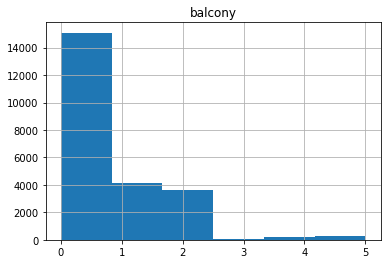

In [103]:
data.hist('balcony', bins=6)

`days_exposition` - сколько дней было размещено объявление. Можно увидеть, что в целом график приемлемый. Нулевых значений нет. Объявления, которые размещены более 3-х лет отбросим:

Объявление не было опубликовано:  0
Объявлению больше 3 лет :  165


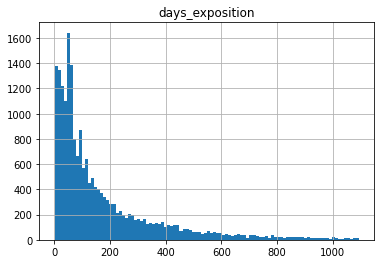

In [104]:
print('Объявление не было опубликовано: ',data.query('days_exposition == 0')['days_exposition'].count())

print('Объявлению больше 3 лет : ',data.query('days_exposition > 365*3')['days_exposition'].count())

data.drop(index=data.query('days_exposition > 365*3').index,inplace=True)

data.hist('days_exposition', bins=100);

Следующие данные собраны автоматически. По гистограммам выглядят приемлемо. Выделяется одна строчка с `airports_nearest`. Квартир ближе 5 км к аэропорту одна, может быть, это ошибка. Убираем эту квартиру, остальные данные нормальные.

- airports_nearest
- city_centers_nearest
- parks_around3000
- parks_nearest
- ponds_around3000
- ponds_nearest

Квартир слишком близких к аэропорту: 1


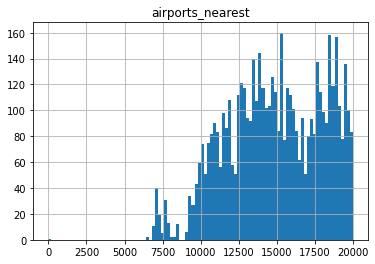

In [105]:
print('Квартир слишком близких к аэропорту:',data.query('airports_nearest < 5000')['airports_nearest'].count())
data.hist('airports_nearest', bins=100, range=(0,20000));

data.drop(index=data.query('airports_nearest < 5000').index,inplace=True)

Cбросим индексацию после удаления строк:

In [106]:
data.reset_index(drop=True,inplace=True)

Показатели о количестве объявлений в датасете, минимальных и максимальных показателях в выбранных параметрах о продаже квартир, "сырые" данные:

In [107]:
(
    data[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  'kitchen_area', 'floor',
       'floors_total']]
    .apply (['count', 'min', 'max'])   
    .style.format("{:,.2f}")
)

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
count,"23,238.00","23,238.00","23,238.00","20,105.00","23,238.00","21,368.00","21,001.00","23,238.00","23,154.00"
min,0.00,12.00,2.50,1.00,"430,000.00",10.00,2.00,1.00,1.00
max,7.00,494.10,4.00,"1,095.00","99,000,000.00",200.00,50.00,27.00,29.00


In [108]:
data.rooms.value_counts().to_frame()

,rooms
1,7957
2,7814
3,5702
4,1138
5,297
0,192
6,94
7,44


In [109]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23238 entries, 0 to 23237
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23238 non-null  int64         
 1   last_price            23238 non-null  int64         
 2   total_area            23238 non-null  float64       
 3   first_day_exposition  23238 non-null  datetime64[ns]
 4   rooms                 23238 non-null  int64         
 5   ceiling_height        23238 non-null  float64       
 6   floors_total          23154 non-null  Int8          
 7   living_area           21368 non-null  float64       
 8   floor                 23238 non-null  int64         
 9   is_apartment          20522 non-null  object        
 10  studio                23238 non-null  bool          
 11  open_plan             23238 non-null  bool          
 12  kitchen_area          21001 non-null  float64       
 13  balcony         

Добавляем и удаляем данные по условиям:
- rooms > 7
- total_area > 500
- days_exposition > 365*3
- last_price > 100.000.000
- living_area > 200
- floors_total > 30

Удалил Null для:
- locality_name
- floors_total

### Посчитайте и добавьте в таблицу новые столбцы

Цена 1 м2:

In [110]:
data['cost_per_sqm'] = data['last_price'] / data['total_area']

День публикации объявления (0 - понедельник, 1 - вторник и т.д.):

In [111]:
data['dayofweek'] = data['first_day_exposition'].dt.dayofweek

Месяц публикации объявления:

In [112]:
data['month'] = data['first_day_exposition'].dt.month

Год публикации объявления:

In [113]:
data['year'] = data['first_day_exposition'].dt.year

Тип этажа квартиры (значения — «первый», «последний», «другой»):

In [114]:
data['floor_category'] = data.apply(
    lambda x: 'первый' if (x.floor == 1) 
    else ('последний' if (x.floor == x.floors_total) & isinstance(x.floors_total,int) 
    else 'другой'), axis=1
)

data['floor_category_digit'] = data.apply(
    lambda x: 0 if (x.floor == 1) 
    else (2 if (x.floor == x.floors_total) & isinstance(x.floors_total,int) 
    else 1), axis=1
)

In [115]:
data['floor_category_digit'].value_counts()

1    17126
2     3242
0     2870
Name: floor_category_digit, dtype: int64

Расстояние в км до центра города:

In [116]:
data['city_centers_nearest_km'] = round(data['city_centers_nearest'] / 1000)
try:
    data['city_centers_nearest_km'] =  data['city_centers_nearest_km'].astype('Int32')
    print('city_centers_nearest_km ok')
except:
    print('city_centers_nearest_km Int32 type conversion fail')

city_centers_nearest_km ok


### Проведите исследовательский анализ данных

Изучаем параметры:

In [117]:
data.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,cost_per_sqm,dayofweek,month,year,floor_category_digit,city_centers_nearest_km
count,23238.000000,2.323800e+04,23238.000000,23238.000000,23238.000000,23154.00000,21368.000000,23238.000000,21001.000000,23238.000000,17759.000000,17779.000000,17780.000000,7849.000000,17780.000000,8847.000000,20105.00000,23238.000000,23238.000000,23238.000000,23238.000000,23238.000000,17779.000000
mean,9.858077,6.108102e+06,59.074842,2.048369,2.702375,10.67673,33.755706,5.888200,10.369042,0.591660,28837.335548,14255.889476,0.604274,490.441203,0.758774,521.744885,171.42855,98173.002968,2.572295,6.399604,2017.386608,1.016008,14.250183
std,5.674362,5.928683e+06,30.372824,1.020545,0.215039,6.53913,19.147684,4.864067,5.113107,0.958633,12671.917542,8577.369000,0.796092,340.188883,0.929011,277.184448,197.24259,42202.335644,1.789668,3.487239,1.020104,0.512613,8.585534
min,0.000000,4.300000e+05,12.000000,0.000000,2.500000,1.00000,10.000000,1.000000,2.000000,0.000000,6450.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.00000,7962.962963,0.000000,1.000000,2014.000000,0.000000,0.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.550000,5.00000,18.600000,2.000000,7.000000,0.000000,18500.000000,9403.000000,0.000000,288.000000,0.000000,299.000000,44.00000,76473.945743,1.000000,3.000000,2017.000000,1.000000,9.000000
50%,9.000000,4.600000e+06,52.000000,2.000000,2.650000,9.00000,30.000000,4.000000,9.000000,0.000000,26835.000000,13145.000000,0.000000,455.000000,0.000000,506.000000,93.00000,94789.198262,3.000000,6.000000,2017.000000,1.000000,13.000000
75%,14.000000,6.700000e+06,69.000000,3.000000,2.750000,16.00000,42.000000,8.000000,12.000000,1.000000,37364.000000,16296.000000,1.000000,612.000000,1.000000,733.000000,224.00000,113761.467890,4.000000,10.000000,2018.000000,1.000000,16.000000
max,50.000000,9.900000e+07,494.100000,7.000000,4.000000,29.00000,200.000000,27.000000,50.000000,5.000000,84853.000000,65952.000000,3.000000,3190.000000,3.000000,1344.000000,1095.00000,848484.848485,6.000000,12.000000,2019.000000,2.000000,66.000000


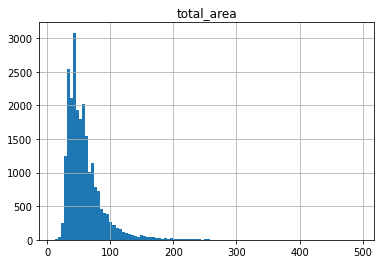

In [118]:
data.hist('total_area', bins=100);

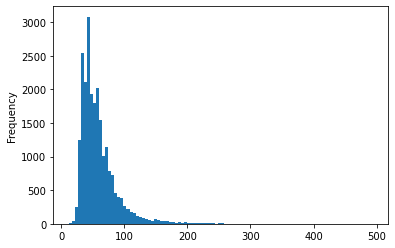

In [119]:
data['total_area'].plot(kind='hist', bins=100);

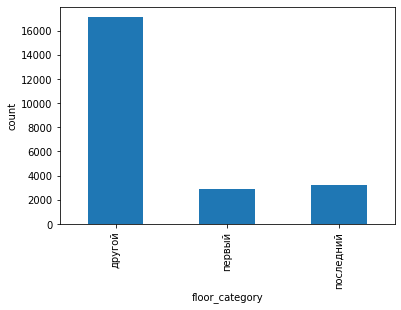

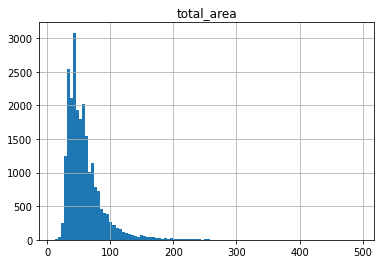

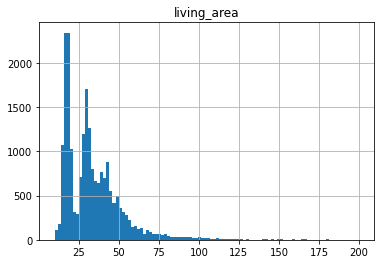

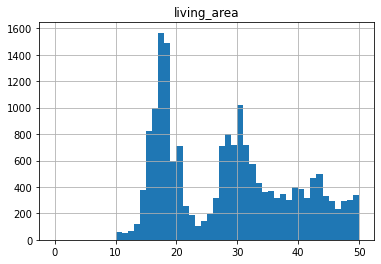

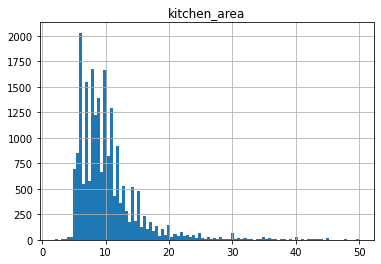

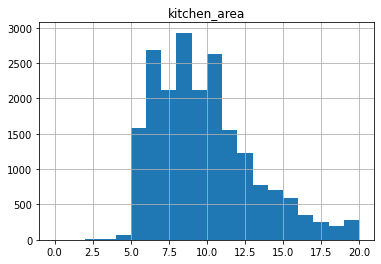

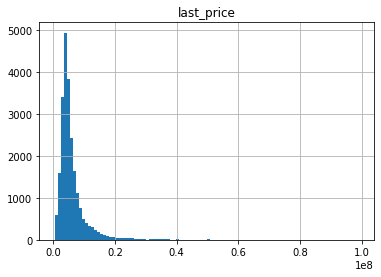

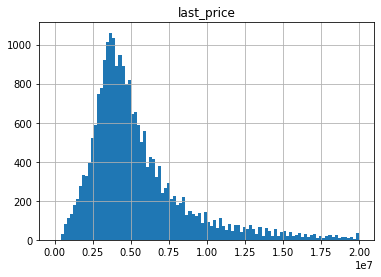

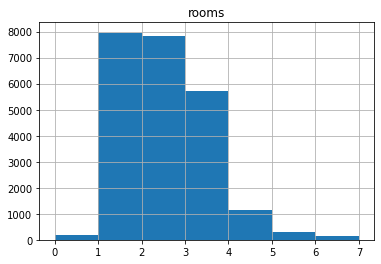

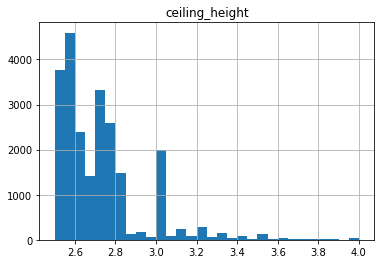

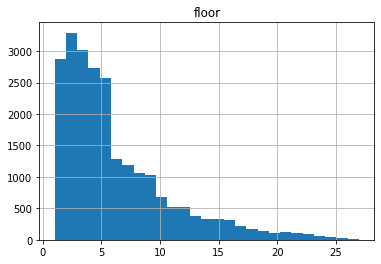

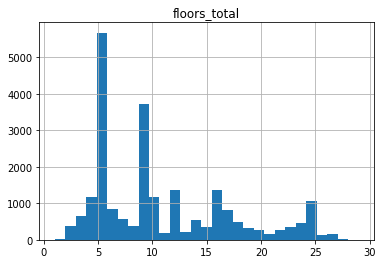

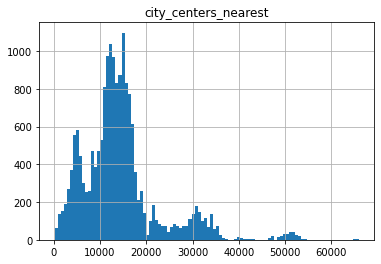

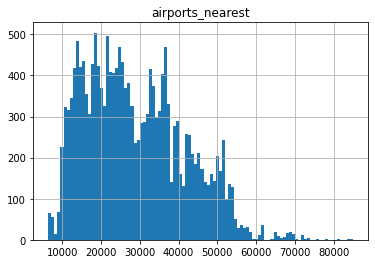

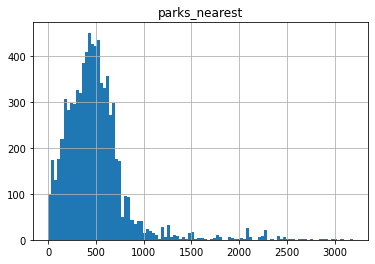

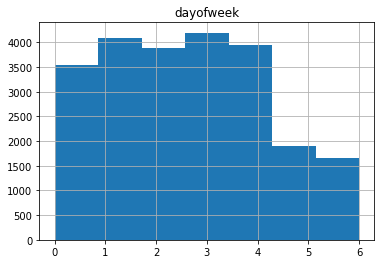

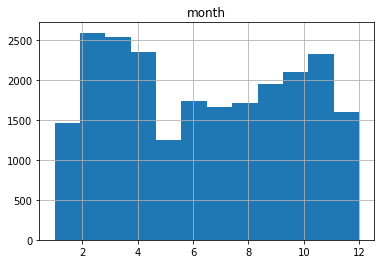

In [120]:
data.groupby(by='floor_category')['floor_category'].count().plot(kind='bar', ylabel = 'count');

data.hist('total_area', bins=100);

data.hist('living_area', bins=100);
data.hist('living_area', bins=50, range=(0,50));

data.hist('kitchen_area', bins=100);
data.hist('kitchen_area', bins=20, range=(0,20));

data.hist('last_price', bins=100);
data.hist('last_price', bins=100, range=(0,2e+07));

data.hist('rooms', bins=data['rooms'].max());

data.hist('ceiling_height', bins=30);

data.hist('floor', bins=data['floor'].max());

data.hist('floors_total', bins=data['floors_total'].max());

data.hist('city_centers_nearest', bins=100);

data.hist('airports_nearest', bins=100);

data.hist('parks_nearest', bins=100);

data.hist('dayofweek', bins=7);

data.hist('month', bins=12);

Построили гистограммы для:

- **тип этажа квартиры** («первый», «последний», «другой») в этом случае используем тип bar. Больше всего квартир на "другом" этаже и это логично. Первых и последних этажей одинакого мало.
- **общая площадь.** Наблюдаем очень малое количество квартир с общей площадью более 100 м2. Если построить "ящик с усами" явно будет немного значений которые покажутся выбросами, но это, скорее всего, дорогостоящая недвижимость.
- **жилая площадь.** Наблюдаем два пика - на 18 м2 и на 30 м2 Нужно проверить, почему у нас именно два пика и почему есть явный провал около 24 м2.
- **площадь кухни.** Площадь кухни выглядит хорошо.
- **цена объекта.** Цена объекта выглядит хорошо. Немного "шумный" график. Очень длинный "хвост" вправо - это похоже дорогостоящая недвижимость.
- **количество комнат.** Больше всего двух- и трёх-комнатных квартир, но встречаются и редкие исключения.
- **высота потолков.** Здесь два пика 2.5м и 3м, что логично.
- **этаж квартиры.** Больше всего квартир с 1 по 5 этаж. Логично, Санкт-Петербург не город небоскрёбов.
- **общее количество этажей в доме.** Явные пики: 5-этажная застройка, 9-этажная застройка, и небольшие пики более высоких новостроек.
- **расстояние до центра города в метрах.** Здесь наблюдаем два пика, один маленький - 5 км и другой побльшой от 10 км до 15 км. Также есть совсем небольшие всплески на 30 км и 50 км.
- **расстояние до ближайшего аэропорта.** Здесь наблюдаем довольно "шумный" график. Но это вполне нормально.
- **расстояние до ближайшего парка.** Судя по графику больше всего квартир с парками на расстоянии до 750м.
- **день и месяц публикации объявления.** Наблюдаем провал в публикации объявлений в субботу и воскресенье, что логично. Так же видим что с февраля по апрель наблюдалась повышенная активность. Также был плавный рост активности с июля по ноябрь. Провалы в декабре, январе и мае.

Построим график значений для столбца с высотой потолков:

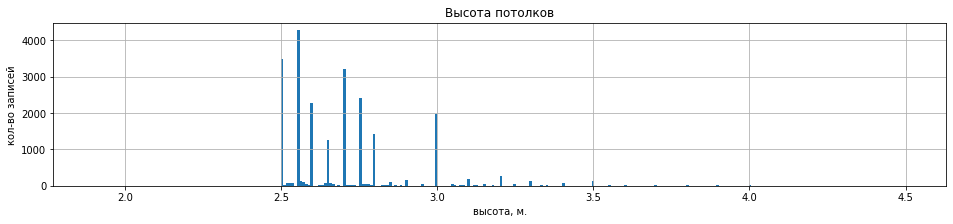

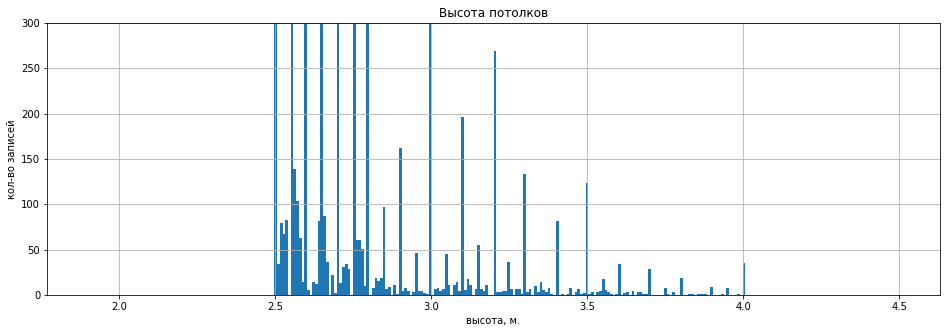

In [121]:
import matplotlib.pyplot as plt

(
    data['ceiling_height']
        .sort_values()
        .plot(y='ceiling_height', kind='hist', 
              bins=300, range=(1.9,4.5), grid=True, title='Высота потолков', figsize=(16,3))        
        .set( ylabel = 'кол-во записей', xlabel = 'высота, м.')
)
plt.show()
(
    data['ceiling_height']
        .sort_values()
        .plot(y='ceiling_height', kind='hist', 
              bins=300, range=(1.9,4.5), grid=True, title='Высота потолков', figsize=(16,5))
        .set(ylim = (0, 300), ylabel = 'кол-во записей', xlabel = 'высота, м.')
        
)
plt.show()

Изучение `days_exposition` - как быстро продавались квартиры:

Среднее время продажи квартиры в днях: 171
Медианное время продажи квартиры в днях: 93

[Выбросы] Количество объявлений, которые сняты через:
45 дней: 870
60 дней: 535
90 дней: 202


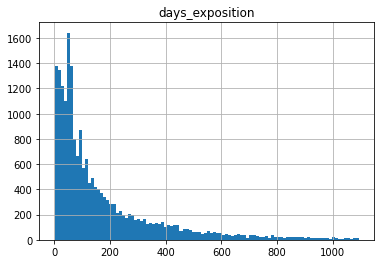

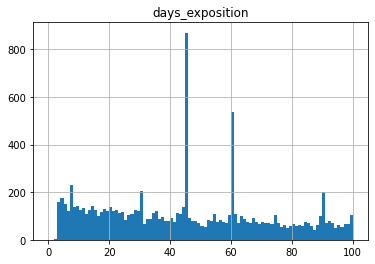

In [122]:
data.hist('days_exposition', bins=100);
data.hist('days_exposition', bins=100, range = (0,100));
print(f'Среднее время продажи квартиры в днях:',int(data['days_exposition'].mean()))
print('Медианное время продажи квартиры в днях:',int(data['days_exposition'].median()))

print('\n[Выбросы] Количество объявлений, которые сняты через:')
print('45 дней:',data[data['days_exposition']==45]['days_exposition'].count())
print('60 дней:',data[data['days_exposition']==60]['days_exposition'].count())
print('90 дней:',data[data['days_exposition']==90]['days_exposition'].count())

Можно сказать, что среднее время продажи квартиры составляет 181 день или целые полгода. Но если взять медиану - то это уже 95 дней, в два раза меньше. Почему так? Потому что у нас есть "длинный хвост" квартир, которые продавались очень долго, буквально годами.
Я бы предложил считать быстрыми продажи до 95 дней, а необычно долгими - свыше 181 дня. Выбросы похожи на платные объявления с истекшим сроком размещения или работу системы удаления неактивных объявлений.

In [123]:
list_for_graph = ['total_area',
                  'living_area',
                  'kitchen_area',
                  'rooms',
                  'floor_category_digit']

for entry in list_for_graph:
    correlation = data['last_price'].corr(data[entry])
    print(f'Корреляция между last_price и {entry} составляет: {correlation:0.2%}')

Корреляция между last_price и total_area составляет: 75.51%
Корреляция между last_price и living_area составляет: 66.55%
Корреляция между last_price и kitchen_area составляет: 56.00%
Корреляция между last_price и rooms составляет: 45.80%
Корреляция между last_price и floor_category_digit составляет: 5.71%


Построение графиков по рекомендациям:

<AxesSubplot:xlabel='last_price', ylabel='kitchen_area'>

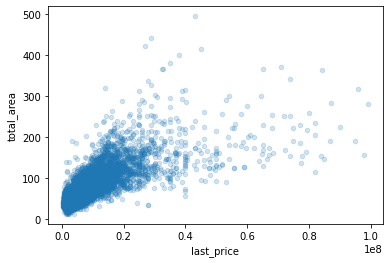

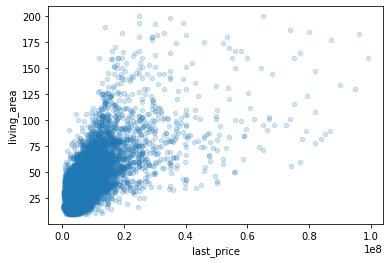

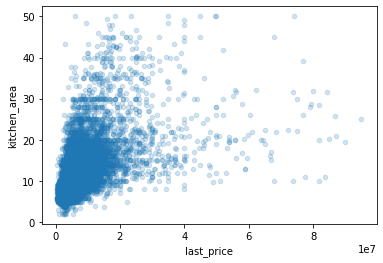

In [124]:
data.plot(x='last_price', y='total_area', kind='scatter', alpha=0.2)
data.plot(x='last_price', y='living_area', kind='scatter', alpha=0.2)
data.plot(x='last_price', y='kitchen_area', kind='scatter', alpha=0.2)

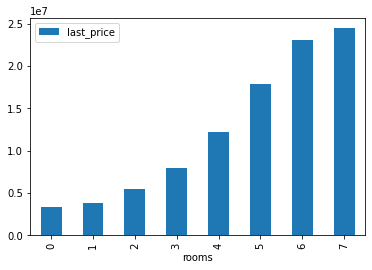

In [125]:
data.pivot_table(index='rooms',values='last_price').plot(y='last_price', kind='bar');

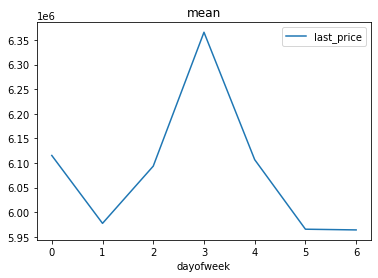

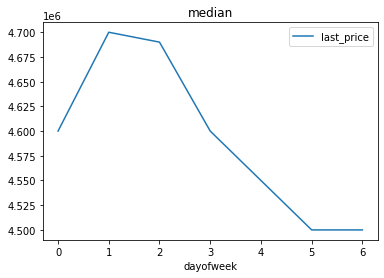

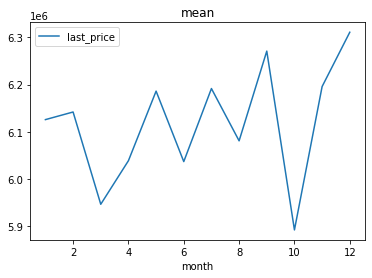

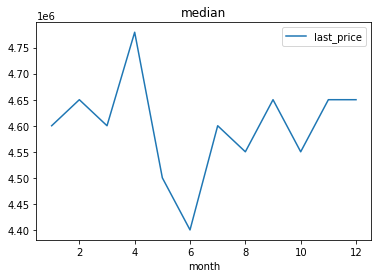

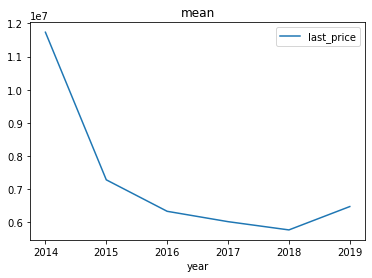

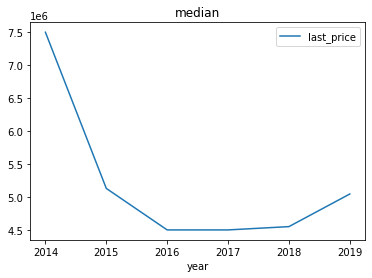

In [126]:
data.pivot_table(index='dayofweek',values='last_price',aggfunc='mean').plot(y='last_price', kind='line', title='mean');
data.pivot_table(index='dayofweek',values='last_price',aggfunc='median').plot(y='last_price', kind='line', title='median');

data.pivot_table(index='month',values='last_price',aggfunc='mean').plot(y='last_price', kind='line', title='mean');
data.pivot_table(index='month',values='last_price',aggfunc='median').plot(y='last_price', kind='line', title='median');

data.pivot_table(index='year',values='last_price',aggfunc='mean').plot(y='last_price', kind='line', title='mean');
data.pivot_table(index='year',values='last_price',aggfunc='median').plot(y='last_price', kind='line', title='median');

Цена по убыванию зависит от:
- общей площади;
- жилой площади;
- площади кухни;
- количества комнат.

Цена практически на зависит от:
- этажа, на котором расположена квартира;
- даты размещения.

<AxesSubplot:xlabel='last_price', ylabel='floor_category'>

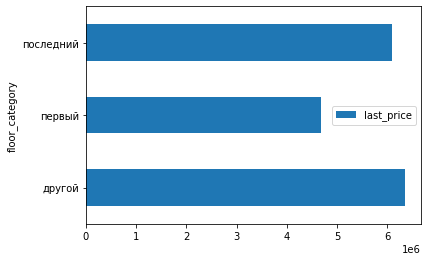

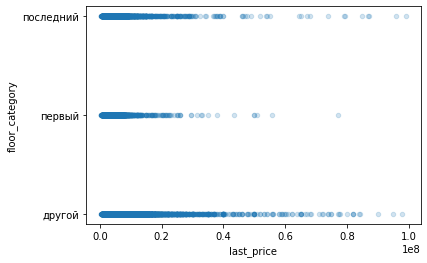

In [127]:
data.pivot_table(index='floor_category',values='last_price').plot(y='last_price', kind='barh');

data.plot(x='last_price', y='floor_category', kind='scatter', alpha=0.2)

Cредняя цена 1 м2 в топ-10 населенных пунктах:

<AxesSubplot:ylabel='locality_name'>

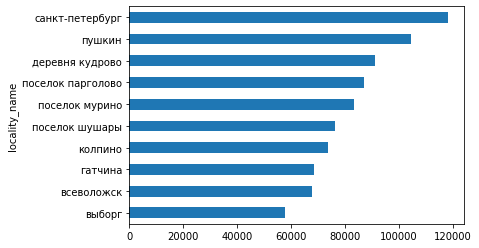

In [128]:
top_10 = data.pivot_table(index='locality_name', values=['last_price','total_area'] ,aggfunc=['sum','count'])
top_10.columns=['last_price_sum','total_area_sum','last_price_count','total_area_count']
top_10.pop('total_area_count')
top_10.sort_values(by=['last_price_count'],ascending=False, inplace=True)
top_10 = top_10.iloc[:10]
top_10['price_per_sq_m'] = top_10['last_price_sum']/top_10['total_area_sum']
top_10.sort_values(by=['price_per_sq_m'],ascending=True, inplace=True)
top_10['price_per_sq_m'].plot(kind='barh')

In [129]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,cost_per_sqm,dayofweek,month,year,floor_category,floor_category_digit,city_centers_nearest_km
0,20,13000000,108.0,2019-03-07,3,2.70,16,51.0,8,False,False,False,25.0,0,санкт-петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,<NA>,120370.370370,3,3,2019,другой,1,16
1,7,3350000,40.4,2018-12-04,1,2.75,11,18.6,1,False,False,False,11.0,2,поселок шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81,82920.792079,1,12,2018,первый,0,19
2,10,5196000,56.0,2015-08-20,2,2.55,5,34.3,4,False,False,False,8.3,0,санкт-петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558,92785.714286,3,8,2015,другой,1,14
3,0,64900000,159.0,2015-07-24,3,2.60,14,NaN,9,False,False,False,NaN,0,санкт-петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424,408176.100629,4,7,2015,другой,1,7
4,2,10000000,100.0,2018-06-19,2,3.03,14,32.0,13,False,False,False,41.0,0,санкт-петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121,100000.000000,1,6,2018,другой,1,8


In [130]:
data['rooms'].value_counts()

1    7957
2    7814
3    5702
4    1138
5     297
0     192
6      94
7      44
Name: rooms, dtype: int64

In [131]:
data.groupby(by='rooms')['rooms'].count().sort_values(ascending=False)

rooms
1    7957
2    7814
3    5702
4    1138
5     297
0     192
6      94
7      44
Name: rooms, dtype: int64

Ожидаемо, что самая дорогая недвижимость в Санкт-Петербурге.
В ТОП-10 входят ближайшие к Санкт-Петербургу города.

Расстояние до центра города:

<AxesSubplot:xlabel='city_centers_nearest_km'>

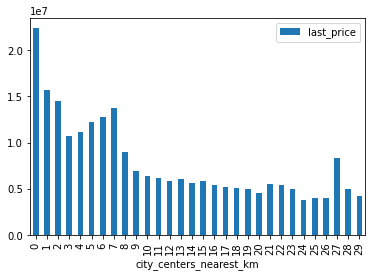

In [132]:
(
    data[data['locality_name']=='санкт-петербург']
    .pivot_table(
        index='city_centers_nearest_km',
        values='last_price',
        aggfunc='mean')
    .plot(kind='bar')
)

С большим отрывом лидирует недвижимость до 1 км.
Видим более низкие цены на недвижимость на расстоянии от 1 км до 7 км включительно.
Далее цена спадает на расстоянии от 8 км до 27 км.
Видим пик на 27 км, его сложно объяснить, возможно это элитная недвижимость.

### Общий вывод

Данное исследование было выполнено для заказчика - сервиса Яндекс.Недвижимость. Целью данного исследования ставилось установить параметры для определеия рыночной стоимости объектов недвижимости.
 
В ходе работы с исходными данными были выявлены и устранены пропуски/отсутствующие значения в таблице, дубликаты. Выявлены и 
устранены редкие и выбивающиеся значения (аномалии) в столбцах таблицы. После избавления нашей базы от 'мусорных' и выбивающихся значений мы выполнили такие операции как подсчёт средней стоимости квадратного метра жилья, стоимость каждого километра удаления от центра, выделили сегмент квартир расположенных в центре и проанализировали их параметры, а так же вывели статистику по скорости продажи объявления с даты его размещения, факторы влияющие на это и проанализировали статистику продаж в зависимости от периода размещения объявления.
 
После изучения данных можно сказать, что можно работать с таблицами, в которых встречаются пропущенные значения. Данные всё-таки лучше очищать от явных "выбросов", но возможно чистить данные придётся после этапа исследовательского анализа данных. В нашем примере - это дорогие квартиры, которые портили корреляции и графики зависимости полной стоимости от разных параметров. Из необычных особенностей:

- В 27 км от центра Санкт-Петербурга есть недвижимость по цене почти равная недвижимости в 8 км. от центра;
- В ТОП-10 входят в основном ближайшие к Санкт-Петербургу города и самые крупные города области:
 - Пушкин;
 - Гатчина;
 - Всеволожск;
 - Выборг.
- Цена в основном зависит от площади квартиры, но корреляция с этажностью (не первый и не последний) видна на графике. Таких квартир явно больше и они явно дороже.
- Быстрые продажи это до 95 дней, а необычно долгие - свыше 181 дня.

**Выбросы:** Количество объявлений, которые сняты через:
- 45 дней: 872
- 60 дней: 536
- 90 дней: 204

Для большей наглядности при анализе использовались графики, из которых легко можно сделать вывод о том, что лидером по размещению объявлений о продаже недвижимости является "Санкт-Петербург. Предполагаю, что данные взяты с площадки, где неактивные объявления автоматически снимаются, если пользователь не продлит время размещения через определёный срок. Либо присутствует платное размещение объявлений.

Рекомендации для заказчика: по результату проделанной работы по обработке и анализу недостающих и "битых" данных, несомненно надо обратить внимание коллег по подготовке и сбору данных на заполняемость ячеек, либо на корректность выгрузки данных из программы. Ошибок связанных с человеческим фактором(опечаток и пр.) довольно мало, что сильно облегчило труд по предобработке материала для анализа.